In [1]:
#import datas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
all_data = pd.DataFrame()
df = pd.read_csv('./TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
all_data = all_data.append(df, ignore_index=True)

df = pd.read_csv('./TrafficLabelling/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
all_data = all_data.append(df, ignore_index=True)

df = pd.read_csv('./TrafficLabelling/Friday-WorkingHours-Morning.pcap_ISCX.csv')
all_data = all_data.append(df, ignore_index=True)

# df = pd.read_csv('./TrafficLabelling/Monday-WorkingHours.pcap_ISCX.csv')
# all_data = all_data.append(df, ignore_index=True)

df = pd.read_csv('./TrafficLabelling/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
all_data = all_data.append(df, ignore_index=True)

# df = pd.read_csv('./TrafficLabelling/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
# all_data = all_data.append(df, ignore_index=True)

df = pd.read_csv('./TrafficLabelling/Tuesday-WorkingHours.pcap_ISCX.csv')
all_data = all_data.append(df, ignore_index=True)

df = pd.read_csv('./TrafficLabelling/Wednesday-workingHours.pcap_ISCX.csv')
all_data = all_data.append(df, ignore_index=True)

print(all_data.shape)

# print(df.describe())
# print(df)
headers = list(df.columns)
print(headers)

(2130459, 85)
['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN

Remove benigns data such that its 50:50

In [2]:
benigns_to_drop = 1019527
# benigns_to_drop = 1500000
current_row = 0

benigns_index = []

while (benigns_to_drop > 0):
    label = all_data[" Label"][current_row]
    if label == "BENIGN":
        benigns_index.append(current_row)
        benigns_to_drop -= 1
    current_row += 1

all_data = all_data.drop(benigns_index)
all_data = all_data.reset_index(drop = True)

Run this to make label binary (benign or not benign)

In [3]:
# for i in range(all_data.shape[0]):
#     if all_data[" Label"][i] == "BENIGN":
#         all_data[" Label"][i] = 0
#     else:
#         all_data[" Label"][i] = 1
        
all_data.loc[all_data[' Label'] == "BENIGN", ' Label'] = 0
all_data.loc[all_data[' Label'] != 0, ' Label'] = 1

Run to see distribution of labels

In [3]:
output_list = {}
for i in range(all_data.shape[0]):
    label = all_data[" Label"][i]
    if label in output_list:
        output_list[label] = output_list[label] + 1
    else:
        output_list[label] = 1

print(output_list)

{'DDoS': 128027, 'PortScan': 158930, 'Bot': 1966, 'Infiltration': 36, 'FTP-Patator': 7938, 'SSH-Patator': 5897, 'BENIGN': 555466, 'DoS slowloris': 5796, 'DoS Slowhttptest': 5499, 'DoS Hulk': 231073, 'DoS GoldenEye': 10293, 'Heartbleed': 11}


In [5]:
# total = 0
# for key, item in output_list.items():
#     if (key == 1):
#         total += item
        
# print(total)
# print(output_list[0])

Run to check and fix for infinity or nan values

In [4]:
pd.options.display.max_rows = 4000
pd.options.mode.use_inf_as_na = True
pd.options.mode.use_inf_as_na = True
all_data['Flow Bytes/s'].fillna(all_data['Flow Bytes/s'].max(),inplace=True)
all_data[' Flow Packets/s'].fillna(all_data[' Flow Packets/s'].max(),inplace=True)
all_data.isna().any()

Flow ID                         False
 Source IP                      False
 Source Port                    False
 Destination IP                 False
 Destination Port               False
 Protocol                       False
 Timestamp                      False
 Flow Duration                  False
 Total Fwd Packets              False
 Total Backward Packets         False
Total Length of Fwd Packets     False
 Total Length of Bwd Packets    False
 Fwd Packet Length Max          False
 Fwd Packet Length Min          False
 Fwd Packet Length Mean         False
 Fwd Packet Length Std          False
Bwd Packet Length Max           False
 Bwd Packet Length Min          False
 Bwd Packet Length Mean         False
 Bwd Packet Length Std          False
Flow Bytes/s                    False
 Flow Packets/s                 False
 Flow IAT Mean                  False
 Flow IAT Std                   False
 Flow IAT Max                   False
 Flow IAT Min                   False
Fwd IAT Tota

Run to remove front columns and seperate the features and label into X and y

In [5]:
headers = headers[7:]
headers = np.delete(headers, [-1], 0)
X = all_data.iloc[:, 7:-1].values
y = all_data.iloc[:, -1].values

In [10]:
for i in range(len(headers)):
    print(i, headers[i])

0  Fwd Packet Length Max
1  Fwd Packet Length Min
2 Bwd Packet Length Max
3  ACK Flag Count
4  Avg Bwd Segment Size
5 Init_Win_bytes_forward
6  Init_Win_bytes_backward


Run to remove redundant features

In [10]:
to_be_removed_headers = [5,6,8,9,10,12,16,17,18,21,22,23,26,27,28,37,38,40,41,70,71,72,74,75,76]
headers = np.delete(headers, to_be_removed_headers, 0)
X = np.delete(X, to_be_removed_headers, 1)

Run to select the 7 best features

In [6]:
indices = np.array([5,6,9,46,53,65,66])
idx = indices + 7

headers = [headers[index] for index in indices]
X = all_data.iloc[:, idx].values
y = all_data.iloc[:, -1].values

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [8]:
model = RandomForestClassifier(n_estimators = 10, criterion = 'gini', max_depth=8)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=10)

In [9]:
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, det_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

fpr , fnr, thresholds = det_curve(y_test, y_pred)
print(fpr)

[[212689   9745]
 [  1571 220368]]
0.9745349064862177
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    222434
           1       0.96      0.99      0.97    221939

    accuracy                           0.97    444373
   macro avg       0.98      0.97      0.97    444373
weighted avg       0.98      0.97      0.97    444373

[1.         0.04381075]


In [ ]:
y_pred2 = model.predict(X_train)
cm = confusion_matrix(y_train, y_pred2)
print(cm)
print(accuracy_score(y_train, y_pred2))
print(classification_report(y_train, y_pred2))

fpr , fnr, thresholds = det_curve(y_test, y_pred)
print(fpr[1])

In [14]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='weighted')

0.8711424339508977

[1 1 1 1 1 1 1]
7
feature:  Fwd Packet Length Max, value: 0.09843
feature:  Fwd Packet Length Min, value: 0.10802
feature: Bwd Packet Length Max, value: 0.09879
feature:  ACK Flag Count, value: 0.15513
feature:  Avg Bwd Segment Size, value: 0.08981
feature: Init_Win_bytes_forward, value: 0.26472
feature:  Init_Win_bytes_backward, value: 0.18510


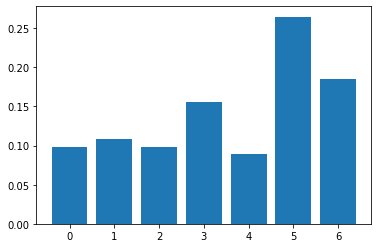

In [20]:
features = model.feature_importances_

refined_features = np.where(features > 0.04, 1, 0)
print(refined_features)
print(np.count_nonzero(refined_features))

for i,v in enumerate(features):
    if (v != 0):
        print('feature: %s, value: %.5f' % (headers[i],v))

plt.bar([x for x in range(len(model.feature_importances_))], model.feature_importances_)
plt.show()

In [34]:
np.argmax(model.feature_importances_)

46

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
accuracy = []
accuracy_train = []
for i in range(2,15):
    model = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', class_weight={0:1,1:200000}, max_depth=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred2 = model.predict(X_train)
    accuracy.append(accuracy_score(y_test, y_pred))
    accuracy_train.append(accuracy_score(y_train, y_pred2))

max_depth: 0, Score: 0.74448
max_depth: 1, Score: 0.74623
max_depth: 2, Score: 0.74943
max_depth: 3, Score: 0.77045
max_depth: 4, Score: 0.77999
max_depth: 5, Score: 0.84280
max_depth: 6, Score: 0.90033
max_depth: 7, Score: 0.89148
max_depth: 8, Score: 0.90796
max_depth: 9, Score: 0.92818
max_depth: 10, Score: 0.96254
max_depth: 11, Score: 0.95559
max_depth: 12, Score: 0.97607


max_depth: 0, Score: 0.74549
max_depth: 1, Score: 0.74704
max_depth: 2, Score: 0.75036
max_depth: 3, Score: 0.77140
max_depth: 4, Score: 0.78021
max_depth: 5, Score: 0.84336
max_depth: 6, Score: 0.90092
max_depth: 7, Score: 0.89116
max_depth: 8, Score: 0.90854
max_depth: 9, Score: 0.92803
max_depth: 10, Score: 0.96293
max_depth: 11, Score: 0.95603
max_depth: 12, Score: 0.97632


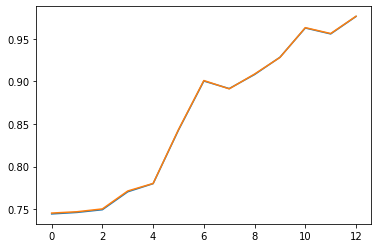

In [14]:
for i,v in enumerate(accuracy):
    print('max_depth: %0d, Score: %.5f' % (i,v))

print("\n")
    
for i,v in enumerate(accuracy_train):
    print('max_depth: %0d, Score: %.5f' % (i,v))

plt.plot([x for x in range(len(accuracy))], accuracy, accuracy_train)
# plt.plot([x for x in range(len(accuracy_train))], accuracy_train)
plt.show()

max_depth: 0, Score: 0.50041
max_depth: 1, Score: 0.50042
max_depth: 2, Score: 0.76431
max_depth: 3, Score: 0.71826
max_depth: 4, Score: 0.76284
max_depth: 5, Score: 0.78475
max_depth: 6, Score: 0.77749
max_depth: 7, Score: 0.85641
max_depth: 8, Score: 0.90303
max_depth: 9, Score: 0.91039
max_depth: 10, Score: 0.93333
max_depth: 11, Score: 0.94976
max_depth: 12, Score: 0.95855
max_depth: 13, Score: 0.96293


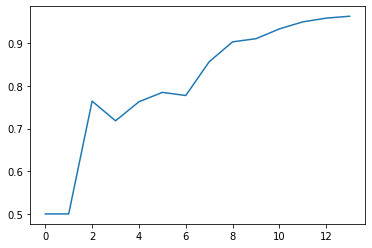

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
accuracy = []
for i in range(1,15):
    model = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', class_weight={0:1,1:200000}, max_depth=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    
for i,v in enumerate(accuracy):
    print('max_depth: %0d, Score: %.5f' % (i,v))

plt.plot([x for x in range(len(accuracy))], accuracy)
plt.show()